In [1]:
import numpy as np
import os
from skimage import io, transform
from tqdm import trange, tqdm
import tensorflow as tf

files_in = os.listdir('cancer_data/inputs')
files = np.random.choice(files_in, 200 )

trd, trl, tstd, tstl = [], [], [], []
for f in tqdm(files):
    if 'train' in f:
        trd.append(transform.resize(io.imread('cancer_data/inputs/' + f), (512,512,3), mode='constant'))
        trl.append(transform.resize(io.imread('cancer_data/outputs/' + f), (512,512,3), mode='constant', order=0))
    else:
        tstd.append(transform.resize(io.imread('cancer_data/inputs/' + f), (512,512,3), mode='constant'))
        tstl.append(transform.resize(io.imread('cancer_data/outputs/' + f), (512,512,3), mode='constant', order=0))

100%|██████████| 200/200 [00:53<00:00,  3.61it/s]


In [2]:
train_data = np.asarray(trd)
train_label = np.asarray(trl)
train_label = train_label[:,:,:,1]
test_data = np.asarray(tstd)
test_label = np.asarray(tstl)
test_label = test_label[:,:,:,1]

In [3]:
def whiten_data(inputs):
    inputs = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)
    return inputs

In [4]:
train_data = whiten_data(train_data)
test_data = whiten_data(test_data)

In [5]:
def conv( x, filter_size=3, stride=1, num_filters=32, is_output=False, name="conv" ):
    shape = x.get_shape().as_list()
    with tf.name_scope(name) as scope:
        W = tf.get_variable("conv_{}_W".format(name), [filter_size, filter_size, x.shape[-1], num_filters], initializer = tf.contrib.layers.variance_scaling_initializer())
        B = tf.get_variable("conv_{}_B".format(name), [num_filters], initializer=tf.ones_initializer())
        conv = tf.nn.conv2d(x, W, [1, stride, stride, 1] , "SAME")
        res = tf.nn.bias_add(conv, B)
        #print "conv ", conv.shape, "res ", res.shape
        if not is_output:
            res = tf.nn.relu(res)
        return res
    pass

In [6]:
f = 'pos_test_000072.png'
test_pic = transform.resize(io.imread('cancer_data/inputs/' + f), (512,512,3), mode='constant')
test_pic = np.reshape(np.asarray(test_pic), (1,512,512,3))

In [11]:
import tensorflow as tf 
import matplotlib.image as image

image.rcParams['image.cmap'] = 'gray'

c = .0001

with tf.Graph().as_default():
    input_data = tf.placeholder( tf.float32, [1,512,512,3] )
    input_label = tf.placeholder(tf.int64, [512,512])
    keep_prob = tf.placeholder(tf.float32)

    with tf.name_scope("network_topology") as scope:
        c0 = conv(input_data, is_output=True, name="c0") #[1,512,512,64] with input [1,512,512,3]
        #c0_1 = tf.nn.dropout(c0, 0.5) #[1,512,512,64]
        c1 = conv(c0,num_filters=15, name="c1") #[1,512,512,64] 
        #c1_1 = tf.nn.dropout(c1, 0.5) #[1,512,512,64]
        #c2 = conv(c1_1, num_filters = 10, name="c2") #[1,512,512,64]
        c3 = conv(c1, num_filters=2, is_output=True, name="c3") #[1,512,512,2]

    with tf.name_scope("cross_entropy") as scope:
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(input_label,(1,512,512)), logits=c3)#+h_L2
    
    with tf.name_scope("train_step") as scope:
        train_step = tf.train.AdamOptimizer(learning_rate=c).minimize(cross_entropy)
        
    with tf.name_scope("predict") as scope:
        prediction = tf.argmax(c3, axis=3)
        
    def accuracy(pred, input_data ):
        pred = np.reshape(pred, (512,512))
        sub = np.equal(input_data, pred)
        accuracy = np.mean(sub.astype(int))
        return accuracy
        
    init = tf.global_variables_initializer()
    sess = tf.Session()
    writer = tf.summary.FileWriter("./tf_lab5", sess.graph)
    sess.run(init)

    epochs = 15
    prob = .8

    logits = []
    train_acc = []
    test_acc = [] 
    for ep in tqdm(xrange(epochs)): 
        im_train_acc = []
        im_test_acc = []
        for im in xrange(train_label.shape[0]):
            _, _, pred = sess.run([cross_entropy, train_step, prediction], feed_dict = {input_data: np.reshape(train_data[im],(1,512,512,3)), input_label: train_label[im], keep_prob: prob })
            tr_acc = accuracy(pred, train_label[im])
            im_train_acc.append(tr_acc)
        train_acc.append(float(sum(im_train_acc))/train_label.shape[0])
        for im in xrange(test_label.shape[0]):
            _, te_pred = sess.run([cross_entropy, prediction], feed_dict = {input_data: np.reshape(test_data[im],(1,512,512,3)), input_label: test_label[im], keep_prob: prob })
            te_acc = accuracy(te_pred, test_label[im])
            im_test_acc.append(te_acc)
        test_acc.append(float(sum(im_test_acc))/test_label.shape[0])
    test_predict = sess.run(prediction, feed_dict = {input_data: np.reshape(test_pic,(1,512,512,3)), input_label: np.reshape(test_pic[:,:,:,1], (512,512)), keep_prob: prob })
    image.imsave('test_im.png', np.reshape(test_predict, (512,512)))
    sess.close()
writer.close()

100%|██████████| 15/15 [48:35<00:00, 194.64s/it]


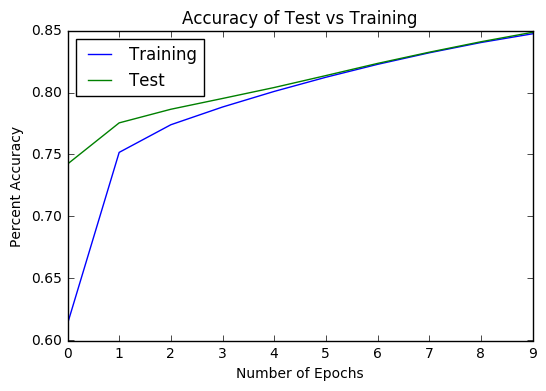

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

plt.plot(train_acc, label='Training')
plt.plot(test_acc, label ='Test')
plt.title("Accuracy of Test vs Training")
plt.xlabel("Number of Epochs")
plt.ylabel("Percent Accuracy")
plt.legend(loc='upper left')
plt.show()